In [1]:
import os
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
from Plotter import format_plot, write_file


In [2]:
def make_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

def plot_eval(experiment_dir, experiment_names, plot_dir, batch_size=128, log_every=100, add_baseline=False):
    for experiment_name in experiment_names:
        val_file = os.path.join(experiment_dir, experiment_name, "val_eval.txt")
        print("Plot accuracy for {}".format(val_file))

        xs = []
        losses = []
        errors = []
        times = []
        with open(val_file) as f:
            for i, line in enumerate(f):
                if "Crossent" in line:
                    continue
                vals = line.rstrip().split(" ")
                crossent = float(vals[0])
                acc = 100. - float(vals[1]) * 100
                losses.append(crossent)
                errors.append(acc)
                x = i * batch_size * log_every / 1000000.
                xs.append(x)

        plt.plot(xs, errors, label=experiment_name + ", Acc:{}".format(min(errors)))
    
    if add_baseline:
        with open("/Users/angela/tmp/Test Accuracy-181115_seedednew_aug-1.0") as f:
            xs = []
            ys = []
            for line in f:
                vals = line.rstrip().split(",")
                xs.append(float(vals[0]))
                ys.append(float(vals[1]))
            plt.plot(xs, ys, label="Our Baseline")
    
    plot_prefix = "{}/{}_val_error".format(plot_dir, experiment_name)
    format_plot("Num Images Trained (millions)", "Error")
    write_file(plot_prefix, show=True)

    
def plot_loss(experiment_dir, experiment_names, plot_dir, batch_size=128, log_every=100, add_baseline=False):
    for experiment_name in experiment_names:
        val_file = os.path.join(experiment_dir, experiment_name, "val_eval.txt")
        print("Plot accuracy for {}".format(val_file))

        xs = []
        losses = []
        accs = []
        times = []
        with open(val_file) as f:
            for i, line in enumerate(f):
                if "Crossent" in line:
                    continue
                vals = line.rstrip().split(" ")
                crossent = float(vals[0])
                losses.append(crossent)
                x = i * batch_size * log_every / 1000000.
                xs.append(x)
        plt.plot(xs, losses, label=experiment_name)

    plot_prefix = "{}/{}_val_losses".format(plot_dir, experiment_name)
    format_plot("Num Images Trained (millions)", "Test Loss")
    write_file(plot_prefix, show=True)

    
def plot_time(experiment_dir, experiment_names, plot_dir, batch_size=128, log_every=100, add_baseline=False):
    for experiment_name in experiment_names:
        val_file = os.path.join(experiment_dir, experiment_name, "val_eval.txt")
        clock_file = os.path.join(experiment_dir, experiment_name, "clock.txt")
        print("Plot time for {}".format(clock_file))

        xs = []
        losses = []
        accs = []
        times = []
        with open(val_file) as f:
            for i, line in enumerate(f):
                if "Crossent" in line:
                    continue
                vals = line.rstrip().split(" ")
                crossent = float(vals[0])
                acc = float(vals[1]) * 100
                losses.append(crossent)
                accs.append(acc)
        
        with open(clock_file) as f:
            for i, line in enumerate(f):
                if (i + 1) % log_every == 0:
                    vals = line.split(" ")
                    xs.append(float(vals[0]))
    
        plt.plot(xs, accs, label=experiment_name)
    
    plot_prefix = "{}/{}_val_accs_by_time".format(plot_dir, experiment_name)
    format_plot("Wall Clock Time", "Accuracies")
    write_file(plot_prefix, show=True)


In [26]:
def plot_keras_output(experiment_dir, experiment_names, plot_dir, by_time=True):
    for experiment_name in experiment_names:
        for filename in os.listdir(os.path.join(experiment_dir, experiment_name)):
            print("Parsing {}".format(filename))

            losses = []
            errors = []
            times = []
            time = 0
            with open(os.path.join(experiment_dir, experiment_name, filename)) as f:
                for i, line in enumerate(f):
                    #if "val_accuracy" not in line and "val_acc" not in line:
                    if "val_accuracy" not in line and "val_acc" not in line or "ETA" in line:
                        continue
                    vals = line.rstrip().split(" ")
                    #time += float(vals[2][:-1])
                    time += float(vals[-14][:-1])
                    err = 1 - float(vals[-1])
                    errors.append(err)
                    times.append(time)
            xs = range(len(errors))
            if len(errors) > 0:
                if by_time:
                    plt.plot(times, errors, label=filename + ", Error:{}".format(min(errors)))
                else:
                    plt.plot(xs, errors, label=filename + ", Error:{}".format(min(errors)))

    if by_time:
        plot_prefix = "{}/{}_val_accs_by_time".format(plot_dir, experiment_name)
        format_plot("Time (s)", "Error")
    else:
        plot_prefix = "{}/{}_val_accs".format(plot_dir, experiment_name)
        format_plot("Epoch", "Error")
    plt.yscale('log')
    write_file(plot_prefix, show=True)

In [4]:
def plot_image_distributions(pickles_dir, plot_dir):
    for filename in os.listdir(pickles_dir):
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            
            subplot_dir = os.path.join(plot_dir, "idxs_hist")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plot_name = os.path.join(subplot_dir, filename+".pdf")
            if os.path.exists(plot_name):
                continue

            d = pickle.load(handle)
            n, bins, patches = plt.hist(d.values(),
                                        50,
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)
            

            plt.xlim(0, max(d.values()) + 1)
            plt.xlabel("Num backprops")
            plt.ylabel("Num images")
            plt.title("{} backprops".format(sum(d.values())))

            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix)

parsing...
plotting...
parsing...
plotting...
../plots/181218_is/181128_oraclegnorm_val_accs.pdf


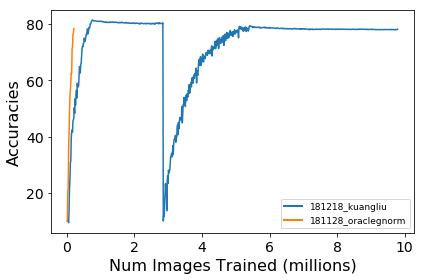

<Figure size 432x288 with 0 Axes>

In [42]:
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/importance_sampling"
experiment_names = ["181218_kuangliu"]
#experiment_names.append("181219_min0.1")
#experiment_names.append("181218_uniform")
experiment_names.append("181128_oraclegnorm")
#experiment_names.append("181218_sb")


plot_dir = os.path.join(plot_home_dir, "181218_is")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
plot_eval(experiment_dir, experiment_names, plot_dir, add_baseline=False)
#plot_time(experiment_dir, experiment_names, plot_dir, add_baseline=False)

In [143]:
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/importance_sampling"
experiment_names = ["181219_baselr_kath"]
#experiment_names.append("181219_primed_sb")
experiment_names.append("181219_baselr_sb")
experiment_names.append("181219_baselr_uniform")
#experiment_names.append("181219_baselr_sequential")

#experiment_names.append("181128_uniform")
#experiment_names.append("181128_oraclegnorm")


plot_dir = os.path.join(plot_home_dir, "181219_is")
make_dir(plot_dir)

#plot_eval(experiment_dir, experiment_names, plot_dir, add_baseline=False)
#plot_time(experiment_dir, experiment_names, plot_dir, add_baseline=False)
for experiment_name in experiment_names:
    experiment_plot_dir = os.path.join(plot_dir, experiment_name)
    make_dir(experiment_plot_dir)
    plot_image_distributions(os.path.join(experiment_dir, experiment_name, "idxs"), experiment_plot_dir)


Plot accuracy for ../data/output/mnist/importance_sampling/181220_init_kath/val_eval.txt
Plot accuracy for ../data/output/mnist/importance_sampling/181220_init_uniform/val_eval.txt
Plot accuracy for ../data/output/mnist/importance_sampling/181220_nomin_sb/val_eval.txt
../plots/181220_mnist_is/181220_nomin_sb_val_accs.pdf


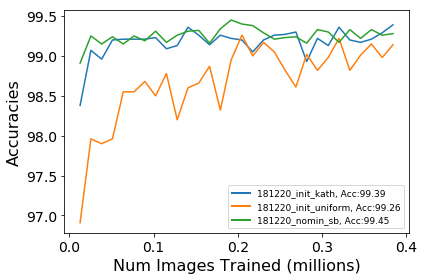

Plot accuracy for ../data/output/mnist/importance_sampling/181220_init_kath/val_eval.txt
Plot accuracy for ../data/output/mnist/importance_sampling/181220_init_uniform/val_eval.txt
Plot accuracy for ../data/output/mnist/importance_sampling/181220_nomin_sb/val_eval.txt
../plots/181220_mnist_is/181220_nomin_sb_val_losses.pdf


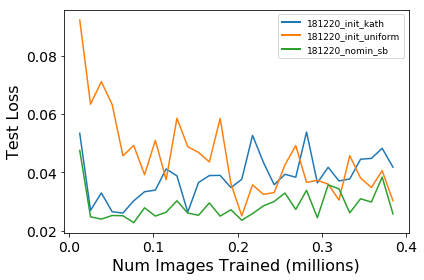

Plot time for ../data/output/mnist/importance_sampling/181220_init_kath/clock.txt
Plot time for ../data/output/mnist/importance_sampling/181220_init_uniform/clock.txt
Plot time for ../data/output/mnist/importance_sampling/181220_nomin_sb/clock.txt
../plots/181220_mnist_is/181220_nomin_sb_val_accs_by_time.pdf


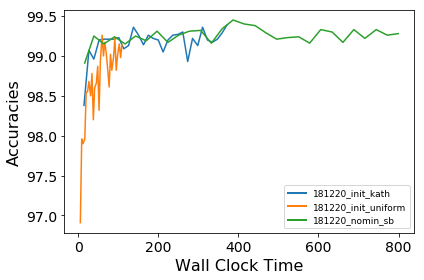

../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist.pickle.pdf
../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist_1172.pickle.pdf
../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist_1563.pickle.pdf
../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist_1954.pickle.pdf
../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist_2345.pickle.pdf
../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist_2736.pickle.pdf
../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist_390.pickle.pdf
../plots/181220_mnist_is/181220_init_kath/idxs_hist/idxs_hist_781.pickle.pdf
../plots/181220_mnist_is/181220_init_uniform/idxs_hist/idxs_hist.pickle.pdf
../plots/181220_mnist_is/181220_init_uniform/idxs_hist/idxs_hist_1172.pickle.pdf
../plots/181220_mnist_is/181220_init_uniform/idxs_hist/idxs_hist_1563.pickle.pdf
../plots/181220_mnist_is/181220_init_uniform/idxs_hist/idxs_hist_1954.pickle.pdf
../plots/181220_mnist_is/181220_init_uniform/idxs_hist/idxs_hist

<Figure size 432x288 with 0 Axes>

In [135]:
plot_home_dir = "../plots"
experiment_dir = "../data/output/mnist/importance_sampling"
experiment_names = ["181220_init_kath"]
experiment_names.append("181220_init_uniform")
#experiment_names.append("181220_init_sb")
experiment_names.append("181220_nomin_sb")


plot_dir = os.path.join(plot_home_dir, "181220_mnist_is")
make_dir(plot_dir)

plot_eval(experiment_dir, experiment_names, plot_dir, add_baseline=False)
plot_loss(experiment_dir, experiment_names, plot_dir, add_baseline=False)
plot_time(experiment_dir, experiment_names, plot_dir, add_baseline=False)
for experiment_name in experiment_names:
    experiment_plot_dir = os.path.join(plot_dir, experiment_name)
    make_dir(experiment_plot_dir)
    plot_image_distributions(os.path.join(experiment_dir, experiment_name, "idxs"), experiment_plot_dir)


Plot accuracy for ../data/output/cifar10/importance_sampling/181220_augmented_kath/val_eval.txt
Plot accuracy for ../data/output/cifar10/importance_sampling/181220_augmented_uniform/val_eval.txt
../plots/181220_cifar10_augmented/181220_augmented_uniform_val_accs.pdf


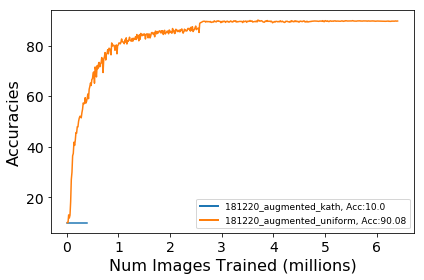

Plot accuracy for ../data/output/cifar10/importance_sampling/181220_augmented_kath/val_eval.txt
Plot accuracy for ../data/output/cifar10/importance_sampling/181220_augmented_uniform/val_eval.txt
../plots/181220_cifar10_augmented/181220_augmented_uniform_val_losses.pdf


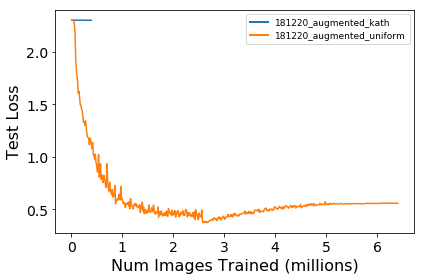

Plot time for ../data/output/cifar10/importance_sampling/181220_augmented_kath/clock.txt
Plot time for ../data/output/cifar10/importance_sampling/181220_augmented_uniform/clock.txt
../plots/181220_cifar10_augmented/181220_augmented_uniform_val_accs_by_time.pdf


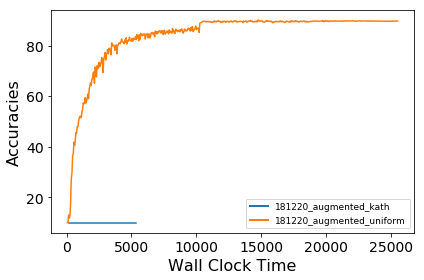

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


../plots/181220_cifar10_augmented/181220_augmented_kath/idxs_hist/idxs_hist_21504.pickle.pdf
../plots/181220_cifar10_augmented/181220_augmented_kath/idxs_hist/idxs_hist_21895.pickle.pdf
../plots/181220_cifar10_augmented/181220_augmented_kath/idxs_hist/idxs_hist_22286.pickle.pdf
../plots/181220_cifar10_augmented/181220_augmented_kath/idxs_hist/idxs_hist_22677.pickle.pdf
../plots/181220_cifar10_augmented/181220_augmented_kath/idxs_hist/idxs_hist_23068.pickle.pdf


<Figure size 432x288 with 0 Axes>

In [8]:
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/importance_sampling"
experiment_names = ["181220_augmented_kath"]
experiment_names.append("181220_augmented_uniform")
#experiment_names.append("181220_augmented_sb")

plot_dir = os.path.join(plot_home_dir, "181220_cifar10_augmented")
make_dir(plot_dir)

plot_eval(experiment_dir, experiment_names, plot_dir, add_baseline=False)
plot_loss(experiment_dir, experiment_names, plot_dir, add_baseline=False)
plot_time(experiment_dir, experiment_names, plot_dir, add_baseline=False)
for experiment_name in experiment_names:
    experiment_plot_dir = os.path.join(plot_dir, experiment_name)
    make_dir(experiment_plot_dir)
    plot_image_distributions(os.path.join(experiment_dir, experiment_name, "idxs"), experiment_plot_dir)


Parsing cifar10_resnet_is
Parsing cifar10_resnet_isbaseline
Parsing cifar10_resnet_sb
../plots/181230_test/181230_test_val_accs_by_time.pdf


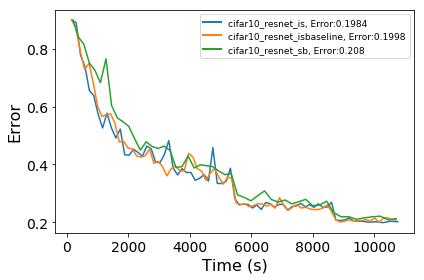

Parsing cifar10_resnet_is
Parsing cifar10_resnet_isbaseline
Parsing cifar10_resnet_sb
../plots/181230_test/181230_test_val_accs.pdf


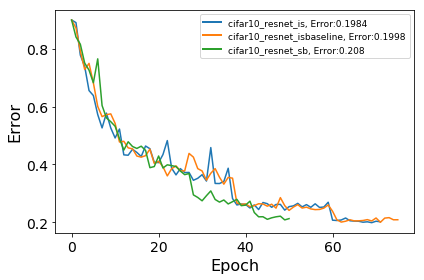

<Figure size 432x288 with 0 Axes>

In [30]:
# Using examples instead of script

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/importance_sampling"
experiment_names = ["181230_test"]

plot_dir = os.path.join(plot_home_dir, "181230_test")
make_dir(plot_dir)

plot_keras_output(experiment_dir, experiment_names, plot_dir)
plot_keras_output(experiment_dir, experiment_names, plot_dir, by_time=False)



Parsing cifar10_resnet_is
Parsing cifar10_resnet_isbaseline
../plots/181230_test_lite/181230_test_lite_val_accs_by_time.pdf


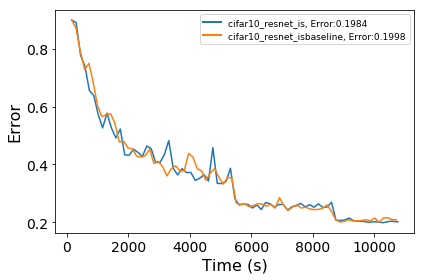

<Figure size 432x288 with 0 Axes>

In [31]:
# Using examples instead of script

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/importance_sampling"
experiment_names = ["181230_test_lite"]

plot_dir = os.path.join(plot_home_dir, "181230_test_lite")
make_dir(plot_dir)

plot_keras_output(experiment_dir, experiment_names, plot_dir)



Parsing is.txt
Parsing is_orig.txt
Parsing uniform_orig.txt
../plots/190120_debug/190120_debug_val_accs_by_time.pdf


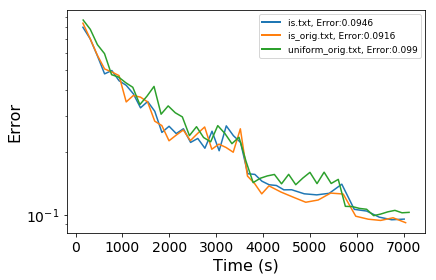

Parsing is.txt
Parsing is_orig.txt
Parsing uniform_orig.txt
../plots/190120_debug/190120_debug_val_accs.pdf


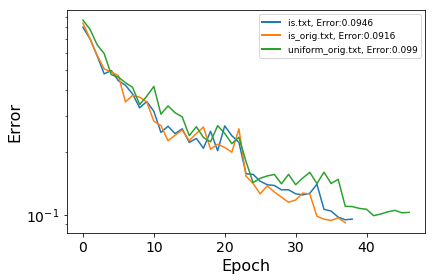

<Figure size 432x288 with 0 Axes>

In [29]:
# Using examples instead of script

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/importance_sampling"
experiment_names = ["190120_debug"]

plot_dir = os.path.join(plot_home_dir, "190120_debug")
make_dir(plot_dir)

plot_keras_output(experiment_dir, experiment_names, plot_dir)
plot_keras_output(experiment_dir, experiment_names, plot_dir, by_time=False)



Parsing is.txt
Parsing is_categorical.txt
Parsing is_nothreshold.txt
Parsing sb.txt
Parsing uniform.txt
../plots/190120_noaug/190120_noaug_val_accs_by_time.pdf


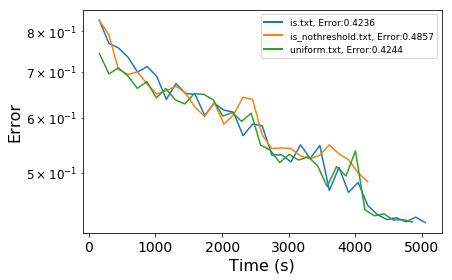

Parsing is.txt
Parsing is_categorical.txt
Parsing is_nothreshold.txt
Parsing sb.txt
Parsing uniform.txt
../plots/190120_noaug/190120_noaug_val_accs.pdf


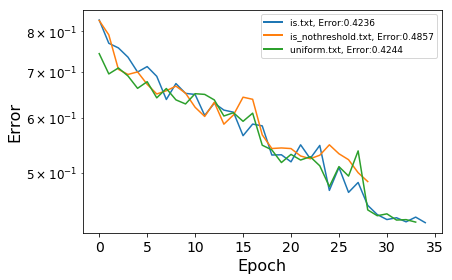

<Figure size 432x288 with 0 Axes>

In [32]:
# Using examples instead of script

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/importance_sampling"
experiment_names = ["190120_noaug"]

plot_dir = os.path.join(plot_home_dir, "190120_noaug")
make_dir(plot_dir)

plot_keras_output(experiment_dir, experiment_names, plot_dir)
plot_keras_output(experiment_dir, experiment_names, plot_dir, by_time=False)

